In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from scipy.integrate import solve_ivp, quad
from scipy.optimize import fsolve
from scipy.spatial.distance import pdist, squareform

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
class Oscillator:
    def __init__(self, m=1, omega=1, kT=0.15, x0=0, xmin=-3, xmax=3, v0=0):
        self.m = m
        self.omega = omega
        self._kT = kT
        self.x0 = x0
        self.xmin = xmin
        self.xmax = xmax
        self.v0 = v0
        self.sigma = (kT/m)**0.5
        self.potential = lambda x: 0.5 * self.m * self.omega**2 * (x-self.x0)**2
        self.probability = lambda x: (self.m*self.omega**2/(2*np.pi*self._kT))**0.5 * np.exp(-self.potential(x)/self._kT)
        self.avg_potential = quad(lambda x: self.potential(x) * self.probability(x), -np.inf, np.inf)[0]
        self.samples = [x0]
    
    @property
    def kT(self):
        return self._kT
    
    @kT.setter
    def kT(self, value):
        self._kT = value
        self.probability = lambda x: (self.m*self.omega**2/(2*np.pi*self._kT))**0.5 * np.exp(-self.potential(x)/self._kT)
        self.avg_potential = quad(lambda x: self.potential(x) * self.probability(x), -np.inf, np.inf)[0]
    
    def step(self, Delta=0.1):
        x_old = self.samples[-1]
        P_old = self.probability(x_old)
        x_new = x_old + Delta*np.random.randn()
        P_new = self.probability(x_new)
        if np.random.rand() < P_new/P_old:
            self.samples.append(x_new)
        else:
            self.samples.append(x_old)
    
    def run(self, N=100000):
        for _ in range(N):
            self.step()
        self.avg_potential_MCMC = np.sum(self.potential(np.array(self.samples))) / N
    
    def velocity_verlet(self, x0=0, v0=0, dt=0.01, N=10000):
        self.xs_verlet = [x0]
        self.vs_verlet = [v0]
        x = x0
        v = v0
        for _ in range(N):
            a = -self.omega**2 * x
            x += v*dt + 0.5*a*dt**2
            a_new = -self.omega**2 * x
            v += 0.5*(a + a_new)*dt
            self.xs_verlet.append(x)
            self.vs_verlet.append(v)
    
    def plot_sampling(self, ax, xwidth=0.1, show_V_avg=True, show_V_avg_MCMC=True):
        # Format
        ax.set(xlabel=r'$x$', ylabel=r'$V$', title=fr'$\langle V \rangle = {self.avg_potential:.3f}$, $\langle V \rangle_{{\text{{MCMC}}}} = {self.avg_potential_MCMC:.3f}$')
        # Plot the potential
        xs = np.linspace(self.xmin, self.xmax, 100)
        ax.plot(xs, self.potential(xs), label='Potential')

        # Plot the probability distribution
        xs = np.arange(self.xmin, self.xmax, xwidth)
        bars, xs = np.histogram(self.samples, xs)

        xvals = 0.5*(xs[1:] + xs[:-1])
        delta_xvals = xvals[1] - xvals[0]
        P = bars / np.sum(bars) / delta_xvals
        width = delta_xvals*0.9
        ax.bar(xvals, P, width=width, label='Probability')

        # Plot the average potential
        if show_V_avg:
            ax.axhline(self.avg_potential, color='tab:orange', linestyle='--', label='Average Potential')

        # Plot the average potential computed from direct sampling
        if show_V_avg_MCMC:
            ax.axhline(self.avg_potential_MCMC, color='tab:green', linestyle='--', label='Average Potential (MCMC)')
        
        ax.text(0.5, 0.5, fr'$kT = {self.kT}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='center', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
        
    def plot_velocity_verlet_positions(self, ax):
        timesteps = range(len(self.xs_verlet))
        positions = self.xs_verlet
        ax.plot(timesteps, positions)
        ax.set(xlabel='Timestep', ylabel='Position', title='Velocity Verlet Positions')
    
    def plot_velocity_verlet_histogram(self, ax, bins=10, height=0.18):
        positions, bin_edges = np.histogram(self.xs_verlet, bins=bins)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        ax.barh(bin_centers, positions, height=height)
        ax.set(xlabel='Observations', ylabel='Positions')
    
    def thermostat(self, N_verlet=50, N_samples=10000):
        self.xs_thermostat = []
        self.vs_thermostat = []
        self.Vs_thermostat = []
        for _ in range(N_samples):
            v0 = np.random.normal(0, self.sigma)
            x0 = self.x0
            self.velocity_verlet(x0=x0, v0=v0, N=N_verlet)
            self.xs_thermostat.append(self.xs_verlet[-1])
            self.Vs_thermostat.append(self.potential(self.xs_verlet[-1]))
            self.vs_thermostat.append(self.vs_verlet[-1])
        self.avg_potential_thermostat = np.sum(self.Vs_thermostat) / N_samples
        self.heat_capacity_thermostat = np.var(self.Vs_thermostat) / self._kT**2
    
    def plot_thermostat_positions(self, ax):
        timesteps = range(len(self.vs_thermostat))
        positions = self.xs_thermostat
        ax.plot(timesteps, positions)
        ax.set(xlabel='Timestep', ylabel='Position', title=fr'$\langle V \rangle = {self.avg_potential_thermostat:.3f}$')
    
    def plot_thermostat_histogram(self, ax, bins=10, height=0.18):
        positions, bin_edges = np.histogram(self.xs_thermostat, bins=bins)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        ax.barh(bin_centers, positions, height=height)
        ax.set(xlabel='Observations', title=fr'$\left( \langle V^2 \rangle - \langle V \rangle^2 \right)/(k_BT^2) = {self.heat_capacity_thermostat:.3f}$')

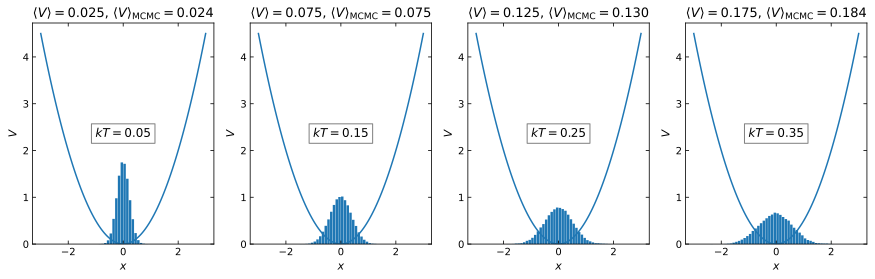

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
kTs = [0.05, 0.15, 0.25, 0.35]
for ax, kT in zip(axs, kTs):
    o = Oscillator(kT=kT)
    o.run()
    o.plot_sampling(ax, show_V_avg=False, show_V_avg_MCMC=False)

fig.savefig('ex24_fig1.png')

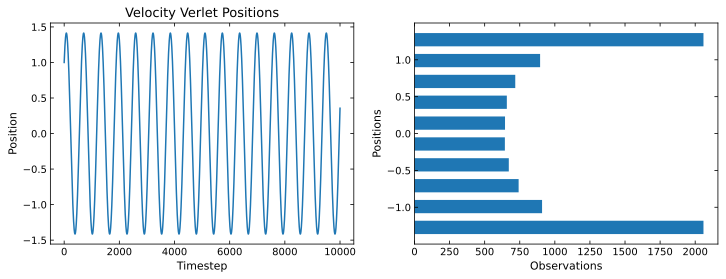

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
o.kT = 0.15
o.velocity_verlet(x0=1, v0=1)
o.plot_velocity_verlet_positions(axs[0])
o.plot_velocity_verlet_histogram(axs[1])

fig.savefig('ex24_fig2.png')

### Constant temperature MD

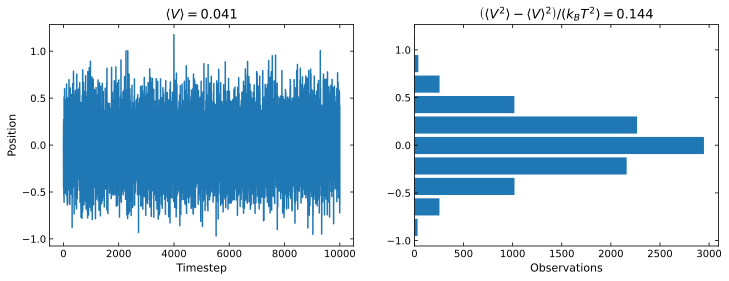

In [5]:
o.thermostat()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
o.plot_thermostat_positions(axs[0])
o.plot_thermostat_histogram(axs[1])

fig.savefig('ex24_fig3.png')